In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML

# Percolação

## Cria condição inicial da percolação para uma probabilidade p em cada ponto


In [ ]:
def criar_grade(p, n):
  np.random.seed(1202)

  lattice = np.zeros([n, n], dtype = 'int')

  for i in range(0, n): 
      for j in range(0, n):
          if np.random.uniform() < p:
              lattice[i,j] = 999

  return lattice

In [ ]:
lattice = criar_grade(0.59, 15)

## Algoritmo de marcação dos clusters

In [ ]:
def find_cluster(lattice, N):
  local_frames_array = []
  
  map_cluster = np.zeros([N+2, N+2], dtype= 'int')
  map_cluster[1:N+1, 1:N+1] = lattice[:,:]

  dx, dy = np.array([-1, 0, 1, 0]), np.array([0,-1,0,1])

  iic = 3
  local_frames_array.append(map_cluster.copy())

  for j in range(1, N+1):
    for k in range(1, N+1):
      size, add_to_size = 0,0

      ##Inicia a marcação de um cluster
      if map_cluster[j,k] == 999:

        map_cluster[j,k] = iic; #Marca o primeiro ponto
        local_frames_array.append(map_cluster.copy()) # Adiciona o estado atual da lattice no array de frames pra animação

        size += 1
        add_to_size += 1

        ##Inicia o algoritmo de procura de vizinhos que percolam
        while(add_to_size > 0):
            add_to_size =  0
            # Definindo o mínimo de espaço necessário que deve ser visitado para procurar pontos visinhos pertencentes ao cluster
            j1, j2 = j, min(N, j+size) 
            k1, k2 = max(1, k-size), min(N, k+size)

            for jj in range(j1, j2+1):
                for kk in range(k1, k2+1):
                    if map_cluster[jj,kk] == 999:
                        if iic in map_cluster[jj+dx[:], kk+dy[:]]:

                            map_cluster[jj, kk] = iic
                            local_frames_array.append(map_cluster.copy()) #Adiciona na animação
                            size += 1
                            add_to_size += 1
        iic += 47
        if iic > 280:
          iic = 7
  return local_frames_array

## Animação

In [ ]:
def main(lattice, interval=200):
  '''Cria a animação 
  Parametros
  -----------
  a : array
    Uma array bidimensional com as posições dos pontos percolaveis(1) e nao percolaveis(0)

  interval : inteiro
    intervalo entre frames da animação em milissegundos
  '''

  N = len(lattice)

  #Configuração da figura
  fig = plt.figure()

  #Cria o gráfico
  cmap = plt.cm.get_cmap("gist_rainbow")
  cmap.set_over(color='grey')
  cmap.set_under(color='white')  
  im = plt.imshow(np.zeros([N+2, N+2], dtype= 'int'), cmap=cmap, interpolation="nearest", vmin=0.99, vmax = 300)

  im.axes.get_xaxis().set_visible(False)
  im.axes.get_yaxis().set_visible(False)

  #Pega os frames
  percolation_frames_array = find_cluster(lattice, N)

  def animate(i):
    im.set_array(percolation_frames_array[i])

  anim = animation.FuncAnimation(fig, animate, frames = len(percolation_frames_array), interval=interval)
  return anim

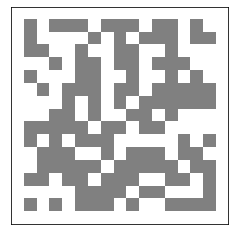

In [ ]:
parametros = main(lattice)
HTML(parametros.to_jshtml())

# parametros.save('cluster_finding.gif', writer='pillow', fps = 10)

# Sandpiles

## Algoritmo

In [46]:
def simulate_sand_pile(N = 100, E = 0.1, critical_slope = 5, n_iter = 20_000, plot = False, record_movement = False, record_sand = False, record_rate = 1_000):
  np.random.seed(0)

  sand = np.zeros(N)
  tsav = np.zeros(n_iter + 1)  #quantity of sand moved in one temporal iteration
  mass = np.zeros(n_iter + 1)  #quatity of sand in all model during one temporal iteration

  if record_movement: move_list = np.zeros([n_iter + 1, N])
  if record_sand: 
    sand_list = np.zeros([int(n_iter / record_rate) + 1, N])
    
  next_instability = set()

  for i in range(1, n_iter + 1):     # temporal iteration

    move = np.zeros(N)
    
    instability = next_instability.copy()
    next_instability.clear()

    for j in instability:

      if j >= 1:
        slope = abs(sand[j - 1] - sand[j])

        if slope >= critical_slope:
          avrg = (sand[j - 1] + sand[j]) / 2
          move[j - 1] += (avrg - sand[j - 1]) / 2
          move[j] += (avrg - sand[j]) / 2
          tsav[i] += slope/4

          next_instability.add(j)
          next_instability.add(j - 1)

      if j < (N - 1):
        slope = abs(sand[j] - sand[j + 1])
          
        if slope >= critical_slope:
          avrg = (sand[j] + sand[j + 1]) / 2
          move[j] += (avrg - sand[j]) / 2
          move[j + 1] += (avrg - sand[j+1]) / 2
          tsav[i] += slope/4

          next_instability.add(j)
          next_instability.add(j + 1)

    if tsav[i] > 0:
      sand += move
    
    else:
      j = np.random.randint(0, N)
      sand[j] += np.random.uniform(0, E)

      next_instability.add(j)

    sand[N - 1] = 0
    mass[i] = np.sum(sand)

    if record_sand and (i % record_rate) == 0:
      sand_list[int(i / record_rate)] = sand.copy()

    if record_movement:
      move_list[i] = np.array([abs(i) for i in move])

  if plot:
    plt.subplot(2, 1, 1)
    plt.plot(range(0, n_iter + 1), mass)
    plt.ylabel('Sandpile Mass')
    plt.subplot(2, 1, 2)
    plt.plot(range(0, n_iter + 1), tsav)
    plt.ylabel('Displaced mass')
    plt.xlabel('iteration')
    plt.show()
  
  return_list = [tsav, mass, 0, 0]
  if record_movement:
    return_list[2] = move_list
  if record_sand:
    return_list[3] = sand_list

  return return_list


# Animação

### Dados para as animações

In [40]:
tsav, mass, move_list, sand_list = simulate_sand_pile(N = 100, n_iter = 2_000_000, record_movement = True, record_sand = True)

2001


### Funções de animação

In [ ]:
def slope_sandpiles(sand_list, interval=400):
  '''Cria a animação 
  Parametros
  -----------
  sand_list: array 2D
    lista com todas as configurações de areia ao longo da simulação 

  interval : inteiro
    intervalo entre frames da animação em milissegundos
  '''
  # Tamanho do eixo x (espaço para a areia)
  N = len(sand_list[0])

  #Configuração da figura
  fig, ax = plt.subplots()
  ax.set(xlim=(0, N), ylim=(0, max(sand_list[-1]) + 100))
  
  ax.set_xticks([])
  ax.set_yticks([])

  #Cria o gráfico
  line, = ax.plot(range(N), [0 for _ in range(N)])

  division = list(map(int, np.linspace(0, 255, len(sand_list))))

  def animate(i):
    line.set_ydata(sand_list[i])

    line.set_color(cm.Wistia(division[i]))
    ax.fill_between(range(N), 0, sand_list[i], color = cm.Wistia(division[i]))

  plt.plot([500 - i * 5 for i in range(100)], '--')
  anim = animation.FuncAnimation(fig, animate,  frames = len(sand_list) - 1, interval=interval)
  return anim

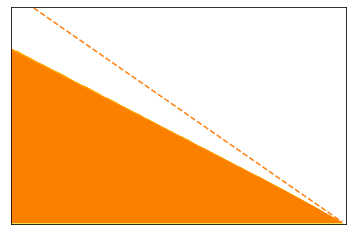

In [32]:
parametros = slope_sandpiles(sand_list, 50)
HTML(parametros.to_html5_video())

In [ ]:
def mass_sandpiles(mass, interval):
  N = int(len(mass) / 10000)
  
  #Configuração da figura
  fig, ax = plt.subplots()
  ax.set(xlim=(0, N), ylim=(0, max(mass) + int(max(mass)/7)))

  #Cria o gráfico
  line, = ax.plot(mass)

  # division = list(map(int, np.linspace(0, 255, N)))

  def animate(i):
    line.set_data(range(i), mass[:i])

    # line.set_color(cm.Wistia(division[i]))
    # ax.fill_between(range(N), 0, mass[i], color = cm.Wistia(division[i]))

  anim = animation.FuncAnimation(fig, animate, frames = N, interval = interval)
  return anim

In [67]:
def mass_sandpiles(mass, interval):
  N = len(mass)
  
  #Configuração da figura
  fig, ax = plt.subplots()
  ax.set(xlim=(0, N), ylim=(0, max(mass) + int(max(mass)/7)))

  #Cria o gráfico
  line, = ax.plot(mass)
  plt.plot(range(N), [175 for _ in range(N)], '--', color = 'grey')

  division = list(map(int, np.linspace(0, 255, N)))

  def animate(i):
    line.set_data(range(i), mass[:i])

    line.set_color(cm.Wistia(division[i]))
    ax.fill_between(range(N), 0, mass[i], color = cm.Wistia(division[i]))

  anim = animation.FuncAnimation(fig, animate, frames = N, interval = interval)
  return anim

In [68]:
_, mass2, _, _  = simulate_sand_pile(N = 10, n_iter = 20_000, record_movement = True, record_sand = False)

CalledProcessError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f32409ac8c0> (for post_execute):


KeyboardInterrupt: ignored

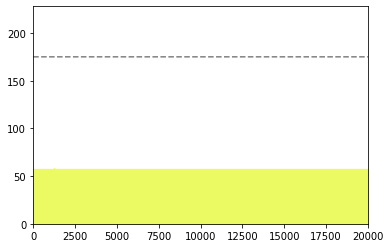

In [ ]:
parametros = mass_sandpiles(mass2, 1)
HTML(parametros.to_html5_video())